# **MIDAS Task 3**

**Please go through the ReadMe for a detailed description**

**Method**

1.   For this experiment, the entire product category is split into levels. An analysis is conducted to figure out the most important level.
2. The levels shortlisted as **the most important**, are Level 1, and a concatenation of Level 1 and 2.
3.   TF-IDF is used to tranform the features to vector representations. Feature used is -> A concatencated text blob of Product Name and Description.
4.   Multiple models are tested to train the same and other preprocessing methods are described in their sections. 


**Sections**

1. Libraries
2. Data Loading and Setup
3. Data Preprocessing, EDA and Cleaning
    *   Preprocessing
    *   EDA to choose categories (Target Selection)
    *   Cleaning Preparation
4. Data Vectorization
5. Training
6. Results Analysis





# **Libraries**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import pickle
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
import re
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from gensim.models import Word2Vec
import time

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\infin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\infin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\infin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\infin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
'''Setting a random seed'''

np.random.seed(500)

# **Data Loading and Setting Up**


In [6]:
'''
LOADING THE DATA AND VISUALISING THE TABLE
Specifying the field to load. Only required fields are loaded.
'''

fields = ['product_name', 'description', 'product_category_tree']

data = pd.read_csv('flipkart_com-ecommerce_sample.csv', usecols=fields)
data.head()

,product_name,product_category_tree,description
0,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",Key Features of Alisha Solid Women's Cycling S...
1,FabHomeDecor Fabric Double Sofa Bed,"[""Furniture >> Living Room Furniture >> Sofa B...",FabHomeDecor Fabric Double Sofa Bed (Finish Co...
2,AW Bellies,"[""Footwear >> Women's Footwear >> Ballerinas >...",Key Features of AW Bellies Sandals Wedges Heel...
3,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",Key Features of Alisha Solid Women's Cycling S...
4,Sicons All Purpose Arnica Dog Shampoo,"[""Pet Supplies >> Grooming >> Skin & Coat Care...",Specifications of Sicons All Purpose Arnica Do...


In [7]:
'''
Combining product_name and description to make the input feature text blob. Removing both after cojoining.
'''

data['NameDesc'] = data['product_name'] + data['description']
data = data.drop(['description', 'product_name'], axis=1)
data.product_category_tree = data.product_category_tree.astype(str)

data.head()

,product_category_tree,NameDesc
0,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",Alisha Solid Women's Cycling ShortsKey Feature...
1,"[""Furniture >> Living Room Furniture >> Sofa B...",FabHomeDecor Fabric Double Sofa BedFabHomeDeco...
2,"[""Footwear >> Women's Footwear >> Ballerinas >...",AW BelliesKey Features of AW Bellies Sandals W...
3,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",Alisha Solid Women's Cycling ShortsKey Feature...
4,"[""Pet Supplies >> Grooming >> Skin & Coat Care...",Sicons All Purpose Arnica Dog ShampooSpecifica...


In [8]:
'''
Observing Basic Features of Table
Note that the unique categories does not take into consideration the levels of the categorisation.
It treat the entire cell as  a unique category.
'''

print('Dataframe Shape:', data.shape)
print('Uniques Categories:', len(data['product_category_tree'].unique()))

print()
print('Unique Categories Count:')
print()

label_count = Counter(data['product_category_tree']).most_common()
print('5 most frequent labels:')
print(*label_count[:5], sep = "\n")
print('\n 5 least frequent labels:')
print(*label_count[-5:], sep = "\n")

Dataframe Shape: (20000, 2)
Uniques Categories: 6466

Unique Categories Count:

5 most frequent labels:
('["Jewellery >> Necklaces & Chains >> Necklaces"]', 1567)
('["Jewellery >> Rings"]', 710)
('["Automotive >> Accessories & Spare parts >> Car Interior & Exterior >> Car Interior >> Car Mats"]', 522)
('["Jewellery >> Bangles, Bracelets & Armlets >> Bangles"]', 430)
('["Tools & Hardware >> Tools >> Gardening Tools >> Plant Containers & Sets >> Plant Container Sets"]', 332)

 5 least frequent labels:
('["Clothing >> Women\'s Clothing >> Western Wear >> Dresses & Skirts >> Dresses >> HUGO CHAVEZ Dresses"]', 1)
('["Clothing >> Women\'s Clothing >> Western Wear >> Dresses & Skirts >> Dresses >> Kashana Fashions Dresses"]', 1)
('["Clothing >> Women\'s Clothing >> Western Wear >> Dresses & Skirts >> Dresses >> Indibox Dresses"]', 1)
('["Baby Care >> Baby & Kids Gifts >> Stickers >> Oren Empower Stickers"]', 1)
('["Baby Care >> Baby & Kids Gifts >> Stickers >> Fun To See Stickers"]', 1)


# **Inferences**

We can observe that using the complete product tree as a unique class is impossible due to extreme data imbalance. Two other methods could be:

1. Train an ensemble of classifiers to predict at every level of the category. 
2. Identify the most important category and predict on that (As specified by the Task)

# **Data Preprocessing, Exploratory Analysis and Cleaning**

#### **Data Preprocessing**

In [9]:
'''
Performing a sample split on the category tree to check.
'''

sample = data.product_category_tree[0]
print(sample, type(sample))

sample = sample[2:]
sample = sample[:-2]
sample = sample.split(sep = ' >> ')

print()
for i in sample:
  print(i)

["Clothing >> Women's Clothing >> Lingerie, Sleep & Swimwear >> Shorts >> Alisha Shorts >> Alisha Solid Women's Cycling Shorts"] <class 'str'>

Clothing
Women's Clothing
Lingerie, Sleep & Swimwear
Shorts
Alisha Shorts
Alisha Solid Women's Cycling Shorts


In [10]:
'''
Defining a function to split category tree into levels of categories.
The function returns the list of lists and the max depth.

max_levels => The deepest tree depth
level_list => List of lists containing the split list of each product.
'''

# Remove blank rows if any.
data.dropna(inplace=True, how='any')

def make_levels(data):
  level_list = []
  max_levels = 0

  for i in tqdm(data.product_category_tree):
    # Split into levels
    temp = i[2:]
    temp = temp[:-2]
    temp = temp.split(sep = ' >> ')

    # Update max levels
    max_levels = max(len(temp), max_levels)
    
    # Pad list with 'None' upto max_levels length
    temp += ['None'] * (max_levels - len(temp))
    
    # Add to level_list
    level_list.append(temp)

  return level_list, max_levels

level_list, max_levels = make_levels(data)

100%|████████████████████████████████████████████████████████████████████████| 19998/19998 [00:00<00:00, 200515.15it/s]


In [11]:
'''
Defining a new dataset with 8 levels (Max Depth) for analysis
'''

cols = ['Level1', 'Level2', 'Level3', 'Level4', 'Level5', 'Level6', 'Level7', 'Level8']
df = pd.DataFrame(level_list, columns = cols)
df['NameDesc'] = data['NameDesc']

df.head()

,Level1,Level2,Level3,Level4,Level5,Level6,Level7,Level8,NameDesc
0,Clothing,Women's Clothing,"Lingerie, Sleep & Swimwear",Shorts,Alisha Shorts,Alisha Solid Women's Cycling Shorts,None,None,Alisha Solid Women's Cycling ShortsKey Feature...
1,Furniture,Living Room Furniture,Sofa Beds & Futons,FabHomeDecor Fabric Double Sofa Bed (Finish Co...,None,None,None,None,FabHomeDecor Fabric Double Sofa BedFabHomeDeco...
2,Footwear,Women's Footwear,Ballerinas,AW Bellies,None,None,None,None,AW BelliesKey Features of AW Bellies Sandals W...
3,Clothing,Women's Clothing,"Lingerie, Sleep & Swimwear",Shorts,Alisha Shorts,Alisha Solid Women's Cycling Shorts,None,None,Alisha Solid Women's Cycling ShortsKey Feature...
4,Pet Supplies,Grooming,Skin & Coat Care,Shampoo,Sicons All Purpose Arnica Dog Shampoo (500 ml),None,None,None,Sicons All Purpose Arnica Dog ShampooSpecifica...


### **Data Visualisation**

In [12]:
'''
Observing the distribution of each Level to observe data imbalance and identify important categories.
'''

#Number of Unique Categories in first three levels
print(df['Level1'].nunique())
print(df['Level2'].nunique())
print(df['Level3'].nunique())

print()

# Mean of frequency of each category in first three levels
print(df['Level1'].value_counts().mean())
print(df['Level2'].value_counts().mean())
print(df['Level3'].value_counts().mean())

265
218
876

75.46415094339622
91.73394495412845
22.828767123287673


Ratio of first 25:  98.11981198119813



<AxesSubplot:>

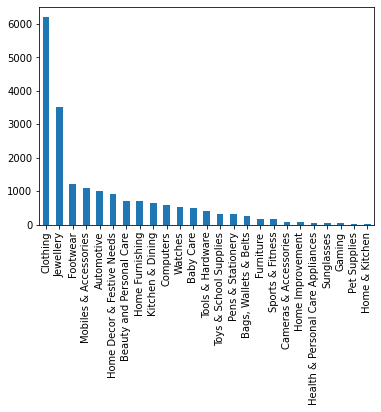

In [13]:
'''
Top 25 categories of Level 1
'''

print('Ratio of first 25: ', (df['Level1'].value_counts()[:25].sum()/df['Level1'].count()) * 100)
print()

plt = df['Level1'].value_counts()[:25].plot(kind='bar')
plt

Ratio of first 25:  82.96829682968297



<AxesSubplot:>

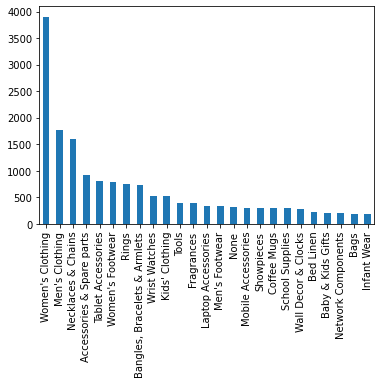

In [14]:
'''
Top 25 categories of Level 2
'''

print('Ratio of first 25: ', (df['Level2'].value_counts()[:25].sum()/df['Level2'].count()) * 100)
print()

plt = df['Level2'].value_counts()[:25].plot(kind='bar')
plt

Ratio of last 20:  0.1000100010001



<AxesSubplot:>

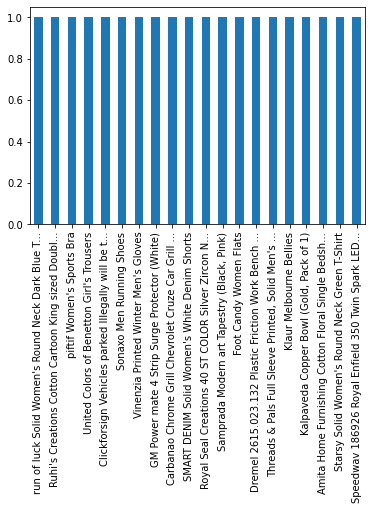

In [15]:
'''
Bottom 20 categories of Level 1
'''

print('Ratio of last 20: ', (df['Level1'].value_counts()[-20:].sum()/df['Level1'].count()) * 100)
print()

plt = df['Level1'].value_counts()[-20:].plot(kind='bar')
plt

456
Ratio of first 30:  84.99349934993499



<AxesSubplot:>

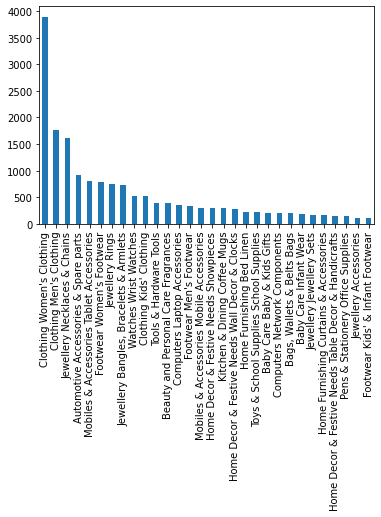

In [16]:
'''
Attempting to combine Level 1 and Level 2 into one category
'''

df['NewCat'] = df['Level1'] + ' ' + df['Level2']
print(df['NewCat'].nunique())

'''
Top 30 categories of Level 1 + Level 2
'''

print('Ratio of first 30: ', (df['NewCat'].value_counts()[:30].sum()/df['NewCat'].count()) * 100)
print()

plt = df['NewCat'].value_counts()[:30].plot(kind='bar')
plt

# **Inferences**

1. 98% of the data, from a frequency point of view, is concentrated in the top 25 categories of the first label. All others have < 10 samples per category and are not of any use.
2. 83% of the data, in a similar manner is placed in the top twenty of the second category.
3. The last 3% of Level 1 of data is well below the mean of 75 occurences, and will be ignored to prevent data imabalance. 
4. Even with the first twenty five categories of level 1 as the target, data imbalance still presents.
5. We also observe, that on combining only level 1 and level 2 into a new primary category, the data imbalance reduces for the first 30 categories.

**Proposed Targets**

1. Attempt Classification on ONLY LEVEL 1 (Top 25 Cats). This Dataset is hereby called data_a.
2. Attempt Classification on LEVEL 1 + LEVEL 2 (Top 30 - Cats). This Dataset is hereby called data_b.

#### **Data Cleaning and Training Prep**

In [17]:
'''
Removing unnecesary columns.
'''

df.drop(['Level3', 'Level4', 'Level5', 'Level6', 'Level7', 'Level8'], axis=1, inplace = True)
data = df
data.head()

,Level1,Level2,NameDesc,NewCat
0,Clothing,Women's Clothing,Alisha Solid Women's Cycling ShortsKey Feature...,Clothing Women's Clothing
1,Furniture,Living Room Furniture,FabHomeDecor Fabric Double Sofa BedFabHomeDeco...,Furniture Living Room Furniture
2,Footwear,Women's Footwear,AW BelliesKey Features of AW Bellies Sandals W...,Footwear Women's Footwear
3,Clothing,Women's Clothing,Alisha Solid Women's Cycling ShortsKey Feature...,Clothing Women's Clothing
4,Pet Supplies,Grooming,Sicons All Purpose Arnica Dog ShampooSpecifica...,Pet Supplies Grooming


In [18]:
'''
Cleaning of features (Name + Description)
'''

# Step 1 : Remove blank rows if any.
data.dropna(inplace=True, how='any')

# Step 2 : Change all the text to lower case.
data['NameDesc'] = [entry.lower() for entry in data['NameDesc']]

# Step 3 :Punctuations removal.
data['NameDesc'] = [re.sub(r'[^\w\s]','',s) for s in data['NameDesc']]

# Step 4 : Tokenization : In this each entry in the corpus will be broken into set of words
data['NameDesc'] = [word_tokenize(entry) for entry in data['NameDesc']]

In [19]:
# Step 5: Removing stop words, apply Word Lemmatizer
# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. 

tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

for index,entry in enumerate(data['NameDesc']):
    # Declaring Empty List to store the final words 
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(entry):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    # The final processed set of words for each iteration will be stored in 'text_final'
    data.loc[index,'text'] = str(Final_words)

In [20]:
'''
Getting names of top 25 level 1 categories and top 30 level1 + level2 categories.
'''

a = data['Level1'].value_counts()[:25].index.tolist()
b = data['NewCat'].value_counts()[:30].index.tolist()

print(a)
print(b)

data.head()

['Clothing', 'Jewellery', 'Footwear', 'Mobiles & Accessories', 'Automotive', 'Home Decor & Festive Needs', 'Beauty and Personal Care', 'Home Furnishing', 'Kitchen & Dining', 'Computers', 'Watches', 'Baby Care', 'Tools & Hardware', 'Toys & School Supplies', 'Pens & Stationery', 'Bags, Wallets & Belts', 'Furniture', 'Sports & Fitness', 'Cameras & Accessories', 'Home Improvement', 'Health & Personal Care Appliances', 'Sunglasses', 'Gaming', 'Pet Supplies', 'Home & Kitchen']
["Clothing Women's Clothing", "Clothing Men's Clothing", 'Jewellery Necklaces & Chains', 'Automotive Accessories & Spare parts', 'Mobiles & Accessories Tablet Accessories', "Footwear Women's Footwear", 'Jewellery Rings', 'Jewellery Bangles, Bracelets & Armlets', 'Watches Wrist Watches', "Clothing Kids' Clothing", 'Tools & Hardware Tools', 'Beauty and Personal Care Fragrances', 'Computers Laptop Accessories', "Footwear Men's Footwear", 'Mobiles & Accessories Mobile Accessories', 'Home Decor & Festive Needs Showpieces', 

,Level1,Level2,NameDesc,NewCat,text
0,Clothing,Women's Clothing,"[alisha, solid, womens, cycling, shortskey, fe...",Clothing Women's Clothing,"['alisha', 'solid', 'womens', 'cycle', 'shorts..."
1,Furniture,Living Room Furniture,"[fabhomedecor, fabric, double, sofa, bedfabhom...",Furniture Living Room Furniture,"['fabhomedecor', 'fabric', 'double', 'sofa', '..."
2,Footwear,Women's Footwear,"[aw, bellieskey, features, of, aw, bellies, sa...",Footwear Women's Footwear,"['aw', 'bellieskey', 'feature', 'aw', 'belly',..."
3,Clothing,Women's Clothing,"[alisha, solid, womens, cycling, shortskey, fe...",Clothing Women's Clothing,"['alisha', 'solid', 'womens', 'cycle', 'shorts..."
4,Pet Supplies,Grooming,"[sicons, all, purpose, arnica, dog, shampoospe...",Pet Supplies Grooming,"['sicons', 'purpose', 'arnica', 'dog', 'shampo..."


In [21]:
'''
Splitting into data_a and data_b

data_a:
-> Features: Concatenation of product_name and product_desc
-> Target: Top 25 categories of Level 1 of product_category_tree

data_b:
-> Features: Concatenation of product_name and product_desc
-> Target: Top 30 categories of Level 1 + Level 30 of product_category_tree
'''


def get_data_a(data, cats):
  data_a = data[data['Level1'].isin(cats)]
  data_a.drop(['Level2', 'NewCat'], axis = 1, inplace = True)
  data_a.reset_index(drop = True, inplace = True)
  return data_a

def get_data_b(data, cats):
  data_b = data[data['NewCat'].isin(cats)]
  data_b.drop(['Level1', 'Level2'], axis = 1, inplace = True)
  data_b.reset_index(drop = True, inplace = True)
  return data_b

data_a = get_data_a(data, a)
data_b = get_data_b(data, b)

C:\Users\infin\miniconda3\lib\site-packages\pandas\core\frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [22]:
'''
Observing Data
'''

# Orginal Data
print(data.shape)

# Data A
print(data_a.shape)

# Data B
print(data_b.shape)

(19998, 5)
(19620, 3)
(16996, 3)


In [23]:
'''
Prepare Train and Test.
Since we have two datasets to test on, we make 2 sets of training and testing data.
'''
# Using data_a
data_a.dropna(inplace=True, how='any')
X_train_a, X_test_a, Y_train_a, Y_test_a = model_selection.train_test_split(data_a['text'], data_a['Level1'], test_size=0.15)

# Using data_b
data_b.dropna(inplace=True, how='any')
X_train_b, X_test_b, Y_train_b, Y_test_b = model_selection.train_test_split(data_b['text'], data_b['NewCat'], test_size=0.15)

<ipython-input-23-24f6343a03cd>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_a.dropna(inplace=True, how='any')
<ipython-input-23-24f6343a03cd>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_b.dropna(inplace=True, how='any')


In [24]:
'''Encoder for output'''

Encoder = LabelEncoder()
Y_train_a = Encoder.fit_transform(Y_train_a)
Y_test_a = Encoder.fit_transform(Y_test_a)

Encoder = LabelEncoder()
Y_train_b = Encoder.fit_transform(Y_train_b)
Y_test_b = Encoder.fit_transform(Y_test_b)

# **Vectorization**

**Using TF-IDF**

In [25]:
# Vectorizing data_a

Tfidf_vect_a = TfidfVectorizer(max_features=15000)
Tfidf_vect_a.fit(data_a['text'])

X_train_tf_a = Tfidf_vect_a.transform(X_train_a)
X_test_tf_a = Tfidf_vect_a.transform(X_test_a)


# Vectorizing data_b

Tfidf_vect_b = TfidfVectorizer(max_features=15000)
Tfidf_vect_b.fit(data_b['text'])

X_train_tf_b = Tfidf_vect_b.transform(X_train_b)
X_test_tf_b = Tfidf_vect_b.transform(X_test_b)

# **Training On Vectorizers**

**Explanation of Training Experiments**

*Experiment 1*

1. TF-IDF Vectors of data_a are used.
2. That is, prediction is performed on 25 categories of Level 1 of product_category_tree.

*Experiment 2*

1. TF-IDF Vectors of data_b are used.
2. That is, prediction is performed on 30 categories of Level 1 concatenated with Level 2 of product_category_tree.

**Note** - For all experiments, SVC was used as a classifier. To obtain best results, GridCV was used for hyperparameter tuning.


**Experiment 1**

In [ ]:
# Classifier - Algorithm - SVM
# GRID CV is used below. First we define the parameters to tune

param_grid = {'C':[1,10],'gamma':[1,0.1], 'kernel':['linear','rbf']}
grid = GridSearchCV(SVC(),param_grid,refit = True, verbose=2)

# Fit the data
grid.fit(X_train_tf_a, Y_train_a)

In [89]:
print(grid.best_params_)

# Predict 
predic = grid.predict(X_test_tf_a)

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


In [91]:
# Evaluate

print(classification_report(Y_test_a, predic))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       164
           1       0.93      0.83      0.88        66
           2       0.91      1.00      0.96        43
           3       0.96      1.00      0.98       102
           4       1.00      0.90      0.95        10
           5       1.00      0.99      1.00       941
           6       1.00      0.96      0.98        84
           7       1.00      0.99      1.00       179
           8       1.00      0.92      0.96        26
           9       1.00      0.80      0.89         5
          10       1.00      1.00      1.00         7
          11       0.00      0.00      0.00         1
          12       0.95      0.97      0.96       159
          13       0.95      0.99      0.97       107
          14       0.93      0.88      0.90        16
          15       0.99      1.00      1.00       508
          16       0.92      0.97      0.94        97
          17       0.95    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Experiment 2**

In [106]:
# Using the same parameters defined before

mod = SVC(C = 10, gamma =  0.1, kernel = 'rbf')
mod.fit(X_train_tf_b, Y_train_b)
predic2 = mod.predict(X_test_tf_b)

In [107]:
# Evaluate

print(classification_report(Y_test_b, predic2))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       139
           1       1.00      1.00      1.00        24
           2       0.91      0.91      0.91        33
           3       0.97      0.91      0.94        35
           4       1.00      0.98      0.99        57
           5       0.96      0.96      0.96        81
           6       0.99      1.00      0.99       261
           7       0.99      1.00      0.99       602
           8       0.97      1.00      0.98        62
           9       1.00      1.00      1.00        31
          10       0.78      0.93      0.85        15
          11       0.78      0.83      0.80        42
          12       0.97      0.91      0.94       124
          13       0.84      0.93      0.88        45
          14       0.75      0.50      0.60        18
          15       1.00      1.00      1.00        29
          16       1.00      1.00      1.00        33
          17       1.00    

## **Evaluation and Results**

**TF-IDF with Grid CV on 25 Categories of Level 1**

1. *Accuracy* - 98%
2. *Unweighted Recall* - 90%
3. *Macro Avg F1 Score* - 91%

Comment - Has a good overall accuracy, but suffers from data imbalance of classes.



---

**TF-IDF with Grid CV on 30 Categories of Level 1 + Level 2**

1. *Accuracy* - 98%
2. *Unweighted Recall* - 96%
3. *Macro Avg F1 Score* - 96%

Comment - Has a good overall accuracy and also has a very good recall for each class. Is able to predict more information (Level 1 + Level 2). Also has reduced issues with data imabalance.]



---




It is clearly seen that the combination of Level 1 and Level 2 of the Product Category Tree works better. Moreover, more information is conveyed through the targets of the same since both level 1 and level 2 are predicted.